# Optimize Baseline Pulses (HB-GRAPE lite via sesolve)

Loads the GRAPE baseline pulses, parameterizes additive harmonic bases (8 for Omega, 4 for Delta), and optimizes the coefficients to maximize terminal population in |1> using QuTiP `sesolve`.

Outputs overwrite the CMA-ES originals folder for consistency:
- notebooks/results/CMA-ES/Omega_Original.npy
- notebooks/results/CMA-ES/Delta_Original.npy
Also saves the loaded baselines as `Omega_Original_base.npy` and `Delta_Original_base.npy` in the same folder.


In [59]:
import numpy as np
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple
import qutip as qt
from scipy.optimize import minimize

# Keep prints compact
np.set_printoptions(precision=4, suppress=True)
import nevergrad as ng
import matplotlib.pyplot as plt


In [60]:
BASE_DIR = Path('/home/yehon/projects/grape-crab-qoc')
GRAPE_DIR = BASE_DIR / 'notebooks' / 'results' / 'GRAPE'
OUT_DIR = BASE_DIR / 'notebooks' / 'results' / 'CMA-ES'

OMEGA_BASE_PATH = GRAPE_DIR / 'OMEGA_baseline.npy'
DELTA_BASE_PATH = GRAPE_DIR / 'DELTA_baseline.npy'

# Time grid — inferred from baseline length over 0.1 us window
DURATION = 0.1


In [61]:
omega_base = np.load(OMEGA_BASE_PATH)
delta_base = np.load(DELTA_BASE_PATH)
assert omega_base.ndim == 1 and delta_base.ndim == 1, 'Expected 1D baseline pulses.'
assert omega_base.shape == delta_base.shape, 'Omega/Delta baseline lengths must match.'
N = omega_base.size
T = DURATION

# Canonical tlist
T_LIST = np.linspace(0.0, T, N)
print(f'Loaded baselines: N={N}, T={T} (s)')

# Save baseline copies for provenance
OUT_DIR.mkdir(parents=True, exist_ok=True)
np.save(OUT_DIR / 'Omega_Original_base.npy', omega_base)
np.save(OUT_DIR / 'Delta_Original_base.npy', delta_base)
print('Saved baseline copies.')


Loaded baselines: N=2000, T=0.1 (s)
Saved baseline copies.


In [62]:
# Penalties and ensemble grids reflecting repository defaults
AREA_TARGET = 4 * np.pi
LAMBDA_PEN  = 1.0

scale_vals = np.linspace(0.9, 1.1, 5)
scale_weights = np.exp(-0.5 * ((scale_vals - 1.0) / 0.1) ** 2)
scale_weights = scale_weights / scale_weights.sum()

detuning_span = 0.1 * float(np.max(np.abs(delta_base)))
if detuning_span <= 0.0:
    detuning_span = 0.1

detuning_offsets = np.linspace(-detuning_span, detuning_span, 5)

SEED   = 42
BUDGET = 2000
np.random.seed(SEED)


In [63]:
def sine_basis_matrix(t: np.ndarray, K: int) -> np.ndarray:
    # Columns: sin(w_k * (t - t0)) with w_k = pi*k/Duration
    t0 = t[0]
    duration = (t[-1] - t[0]) if t[-1] != t[0] else 1.0
    cols = []
    for k in range(1, K + 1):
        w_k = np.pi * k / duration
        cols.append(np.sin(w_k * (t - t0)))
    return np.column_stack(cols) if cols else np.zeros((t.size, 0))

K_OMEGA = 8
K_DELTA = 4

PHI_OMEGA = sine_basis_matrix(T_LIST, K_OMEGA)
PHI_DELTA = sine_basis_matrix(T_LIST, K_DELTA)

n_omega = PHI_OMEGA.shape[1]
n_delta = PHI_DELTA.shape[1]
print(f'Basis dims: omega={n_omega}, delta={n_delta}')


Basis dims: omega=8, delta=4


In [64]:
sx = qt.sigmax(); sz = qt.sigmaz()
ket0 = qt.basis(2, 0)
proj1 = qt.basis(2, 1) * qt.basis(2, 1).dag()


def coeff_from_values(values: np.ndarray):
    values = np.asarray(values, dtype=float)
    def f(t, _=None):
        return np.interp(t, T_LIST, values)
    return f


def build_controls(theta: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    theta_omega = theta[:n_omega]
    theta_delta = theta[n_omega:]
    omega = omega_base + PHI_OMEGA @ theta_omega
    delta = delta_base + PHI_DELTA @ theta_delta
    return omega, delta


def run_dynamics(omega: np.ndarray, delta: np.ndarray):
    H = [
        [0.5 * sx, coeff_from_values(omega)],
        [0.5 * sz, coeff_from_values(delta)],
    ]
    return qt.sesolve(H, ket0, T_LIST)


def pulse_area(omega: np.ndarray) -> float:
    return float(np.trapezoid(omega, T_LIST))


def inst_ground_ket(omega_t: float, delta_t: float):
    H = omega_t * sx + delta_t * sz
    vals, vecs = H.eigenstates()
    return vecs[int(np.argmin(vals))]


def objective_factory(kind: str):
    def obj(theta: np.ndarray) -> float:
        omega, delta = build_controls(theta)
        res = run_dynamics(omega, delta)
        psiT = res.states[-1]
        fid = float(qt.expect(proj1, psiT))
        total = 1.0 - fid
        area_pen = LAMBDA_PEN * max(0.0, pulse_area(np.abs(omega)) - AREA_TARGET) ** 2
        total += area_pen

        if kind == 'adiabatic':
            misalign = []
            for psi, omega_t, delta_t in zip(res.states, omega, delta):
                g = inst_ground_ket(float(omega_t), float(delta_t))
                overlap = abs(g.overlap(psi)) ** 2
                misalign.append(1.0 - float(overlap))
            if misalign:
                total += float(np.mean(misalign))

        # elif kind == 'alt_adiabatic': # (disabled for now)
        #     domega_dt = np.gradient(omega, T_LIST)
        #     ddelta_dt = np.gradient(delta, T_LIST)
        #     numerator = np.abs(delta * domega_dt - omega * ddelta_dt)
        #     denom = 2.0 * np.power(np.sqrt(np.clip(omega**2 + delta**2, 1e-12, None)), 3)
        #     with np.errstate(divide='ignore', invalid='ignore'):
        #         adiab_metric = np.nan_to_num(numerator / denom, nan=0.0, posinf=0.0, neginf=0.0)
        #     total += float(np.max(adiab_metric))

        elif kind == 'ensemble':
            sigma_det = 0.1 * float(abs(delta[0]))
            if sigma_det <= 0.0:
                sigma_det = 0.1
            det_weights = np.exp(-0.5 * (detuning_offsets / sigma_det) ** 2)
            det_weights = det_weights / det_weights.sum()

            weighted_sum = 0.0
            for sc, w_beta in zip(scale_vals, scale_weights):
                omega_scaled = sc * omega
                omega_func = coeff_from_values(omega_scaled)
                for dop, w_det in zip(detuning_offsets, det_weights):
                    delta_shifted = delta + dop
                    delta_func = coeff_from_values(delta_shifted)
                    H_ad = [
                        [0.5 * sx, omega_func],
                        [0.5 * sz, delta_func],
                    ]
                    psiT_e = qt.sesolve(H_ad, ket0, T_LIST).states[-1]
                    overlap = float(qt.expect(proj1, psiT_e))
                    err = 1.0 - overlap
                    weighted_sum += w_beta * w_det * err
            total += float(weighted_sum)

        return float(total)
    return obj


In [ ]:
# CMA-ES with Nevergrad over three objectives (Fidelity, Adiabatic, Ensemble)
objectives = {
    'Fidelity':  'terminal',
    'Adiabatic': 'adiabatic',
    'Ensemble':  'ensemble',
}

solutions: dict[str, np.ndarray] = {}
cost_histories: dict[str, np.ndarray] = {}

for name, kind in objectives.items():
    rng = np.random.RandomState(SEED)
    param = ng.p.Array(shape=(n_omega + n_delta,))
    param.random_state = rng
    opt = ng.optimizers.CMA(parametrization=param, budget=BUDGET)

    obj = objective_factory(kind)
    best = None
    history = []
    for _ in range(BUDGET):
        x = opt.ask()
        loss = obj(x.value)
        history.append(loss)
        opt.tell(x, loss)
        if best is None or loss < best[0]:
            best = (loss, x.value.copy())
    print(f'{name}: best loss = {best[0]:.6e}')
    solutions[name] = best[1]
    cost_histories[name] = np.asarray(history, dtype=float)


Fidelity: best loss = 3.517657e-10


Saved CMA-ES cost histories to /home/yehon/projects/grape-crab-qoc/results/results/cma_es_cost_histories.npz


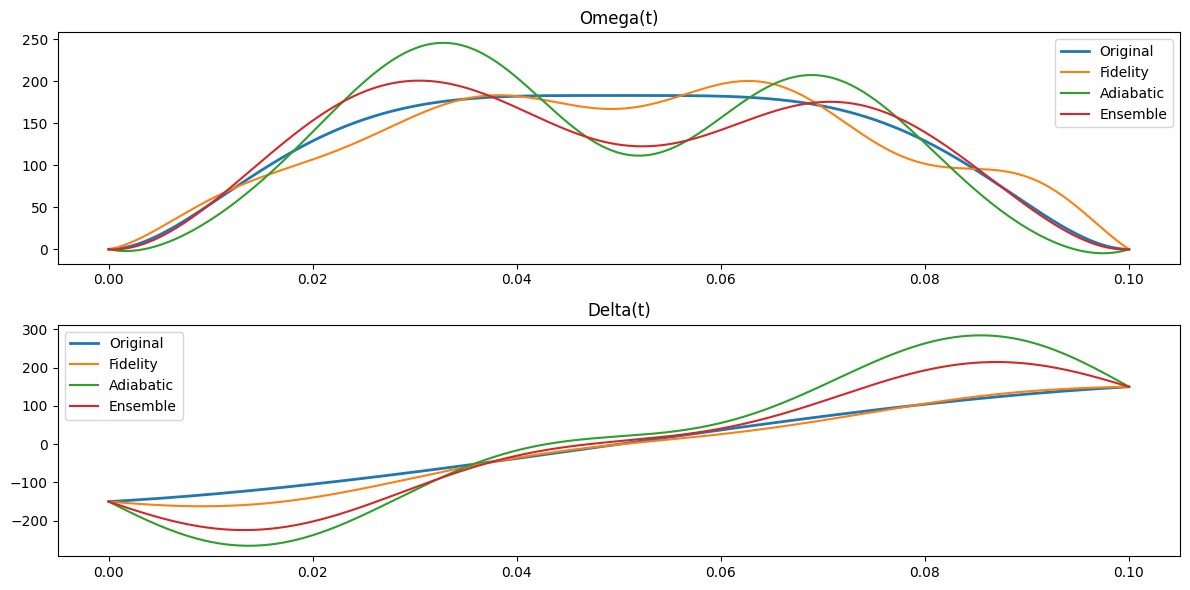

In [ ]:
# Build and save pulses for each solution
np.save(OUT_DIR / 'Omega_Original.npy', omega_base)
np.save(OUT_DIR / 'Delta_Original.npy', delta_base)

for name, theta in solutions.items():
    om, de = build_controls(theta)
    if name == 'Fidelity':
        np.save(OUT_DIR / 'Omega_Fidelity.npy', om)
        np.save(OUT_DIR / 'Delta_Fidelity.npy', de)
    elif name == 'Adiabatic':
        np.save(OUT_DIR / 'Omega_Adiabatic.npy', om)
        np.save(OUT_DIR / 'Delta_Adiabatic.npy', de)
    elif name == 'Ensemble':
        np.save(OUT_DIR / 'Omega_Ensemble.npy', om)
        np.save(OUT_DIR / 'Delta_Ensemble.npy', de)

cost_dir = BASE_DIR / 'results' / 'results'
cost_dir.mkdir(parents=True, exist_ok=True)
np.savez(cost_dir / 'cma_es_cost_histories.npz', **cost_histories)
print(f"Saved CMA-ES cost histories to {cost_dir / 'cma_es_cost_histories.npz'}")

# Quick plot overlay to inspect results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(T_LIST, omega_base, label='Original', lw=2)
for name, theta in solutions.items():
    om, _ = build_controls(theta)
    plt.plot(T_LIST, om, label=name)
plt.title('Omega(t)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(T_LIST, delta_base, label='Original', lw=2)
for name, theta in solutions.items():
    _, de = build_controls(theta)
    plt.plot(T_LIST, de, label=name)
plt.title('Delta(t)')
plt.legend()
plt.tight_layout()
